# CS579: Lecture 10  

**Sentiment Analysis**

*[Dr. Aron Culotta](http://cs.iit.edu/~culotta)*  
*[Illinois Institute of Technology](http://iit.edu)*

*Warning: Live Twitter data is used below, some or all of which may be offensive.*

Discussion of project:

https://github.com/iit-cs579/assignments/tree/master/project

<br><br><br>

## Content Analysis

Rather than just analyzing a network, we will now turn to analyzing what is said within the network.

### Sentiment Analysis

**sen·ti·ment**

1. a view of or attitude toward a situation or event; an opinion.
2. a feeling or emotion.


**sen·ti·ment &nbsp; a·nal·y·sis ** 

1. classification of documents/messages by sentiment

# Examples

![tmnt.png](tmnt.png)

![ufo](ufo.png)

![ufo-review](ufo-review.png)

![mcds](mcds.png)

![rauner](rauner.png)
![quinn](quinn.png)

## Why is this hard?

<br><br>


# Two Approaches

- Lexicons (word lists)

- Machine learning

# Lexicons

- List of terms with positive/negative/neutral sentiment

- E.g., AFINN: https://github.com/fnielsen/afinn


In [37]:
# Download the AFINN lexicon, unzip, and read the latest word list in AFINN-111.txt
from collections import defaultdict
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

url = urlopen('http://www2.compute.dtu.dk/~faan/data/AFINN.zip')
zipfile = ZipFile(BytesIO(url.read()))
afinn_file = zipfile.open('AFINN/AFINN-111.txt')

afinn = dict()

for line in afinn_file:
    parts = line.strip().split()
    if len(parts) == 2:
        afinn[parts[0].decode("utf-8")] = int(parts[1])

print('read %d AFINN terms.\nE.g.: %s' % (len(afinn), 
                                          str(list(afinn.items())[:10])))

read 2462 AFINN terms.
E.g.: [('abandon', -2), ('abandoned', -2), ('abandons', -2), ('abducted', -2), ('abduction', -2), ('abductions', -2), ('abhor', -3), ('abhorred', -3), ('abhorrent', -3), ('abhors', -3)]


In [64]:
len(afinn)

2462

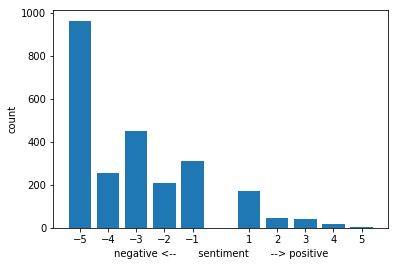

In [65]:
# What is the distribution of scores?
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

counts = Counter(afinn.values())
vals = sorted(counts.keys())

plt.bar(vals, counts.values())
plt.xticks(vals)
plt.xlabel('negative <--       sentiment       --> positive')
plt.ylabel('count')
plt.show()

In [67]:
# How should we score a document?


def afinn_sentiment(terms, afinn):
    total = 0.
    for t in terms:
        if t in afinn:
            print('\t%s=%d' % (t, afinn[t]))
            total += afinn[t]
    return total
    
doc = "i don't know if this is a scam or if mine was broken".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	scam=-2
	broken=-1
AFINN:  -3.0


In [68]:
# What if mixed sentiment?
doc = "it has a hokey plot that is both too good and bad".split()
print('AFINN: ', afinn_sentiment(doc, afinn))

	good=3
	bad=-3
AFINN:  0.0


In [69]:


# Distinguish neutral from pos/neg.
# Return two scores per document.
def afinn_sentiment2(terms, afinn, verbose=False):
    pos = 0
    neg = 0
    for t in terms:
        if t in afinn:
            if verbose:
                print('\t%s=%d' % (t, afinn[t]))
            if afinn[t] > 0:
                pos += afinn[t]
            else:
                neg += -1 * afinn[t]
    return pos, neg

doc = "it has a hokey plot that is both to good and bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	good=3
	bad=-3
AFINN: (3, 3)


In [70]:
doc = "the plot is not bad".split()
print('AFINN:', afinn_sentiment2(doc, afinn, verbose=True))

	bad=-3
AFINN: (0, 3)


In [71]:
import configparser
from TwitterAPI import TwitterAPI

# Get some tweets about McDonald's

def get_twitter(config_file):
    """ Read the config_file and construct an instance of TwitterAPI.
    Args:
      config_file ... A config file in ConfigParser format with Twitter credentials
    Returns:
      An instance of TwitterAPI.
    """
    config = configparser.ConfigParser()
    config.read(config_file)
    twitter = TwitterAPI(
                   config.get('twitter', 'consumer_key'),
                   config.get('twitter', 'consumer_secret'),
                   config.get('twitter', 'access_token'),
                   config.get('twitter', 'access_token_secret'))
    return twitter

twitter = get_twitter('twitter.cfg')
tweets = []
for r in twitter.request('search/tweets',
                         {'q': 'mcdonalds', 
                          'count': 100, 
                          'lang': 'en'}):
    if r['user']['screen_name'] != 'mcdonalds': # exclude tweets from @mcdonalds
        tweets.append(r)

In [72]:
print('read %d mcdonalds tweets' % len(tweets))

read 100 mcdonalds tweets


In [73]:
# Tokenize tweets
import re

# \w = [a-zA-Z0-9_]
def tokenize(text):
    return re.sub('\W+', ' ', text.lower()).split()

tokens = [tokenize(t['text']) for t in tweets]
print('tokenized, e.g., \n%s\nto\n%s' % 
      (tweets[6]['text'], tokens[10]))
#tweets[50]['user']['name']
# tweets[50]['user']['screen_name']

tokenized, e.g., 
RT @_SJPeace_: This RACIST white man, a PROUD RACIST at that, verbally assaulted and harassed a young hispanic girl for speaking Spanish wi…
to
['rt', '_sjpeace_', 'this', 'racist', 'white', 'man', 'a', 'proud', 'racist', 'at', 'that', 'verbally', 'assaulted', 'and', 'harassed', 'a', 'young', 'hispanic', 'girl', 'for', 'speaking', 'spanish', 'wi']


In [75]:
tokenize("Hi there how are you? Don't you ... #awesome @awesome http://www.good.com")

['hi',
 'there',
 'how',
 'are',
 'you',
 'don',
 't',
 'you',
 'awesome',
 'awesome',
 'http',
 'www',
 'good',
 'com']

In [77]:
positives = []
negatives = []
for token_list, tweet in zip(tokens, tweets):
    pos, neg = afinn_sentiment2(token_list, afinn)
    if pos > neg:
        positives.append((tweet['text'], pos, neg))
    elif neg > pos:
        negatives.append((tweet['text'], pos, neg))

In [78]:
len(negatives)

50

In [79]:
len(positives)

11

In [80]:
# Print top positives:
for tweet, pos, neg in sorted(positives,
                              key=lambda x: x[1],
                              reverse=True):
    print(pos, neg, tweet)

6 0 @Nestle, customers are wondering... now that your plant-based Awesome Burger has launched in the United States is a… https://t.co/6L7lFAr8uk
4 0 i really have to walk to mcdonalds everyday if i want good hash browns.... ugh
4 0 @McDonalds I nominate my dear friend Mel @Minderblender as a brew-gooder as she's one of my MVPs and one-of-a-kind… https://t.co/sPdFgW7xwc
4 0 @toryboypierce @johnmcdonnellMP Pretty much when my dad said we'd go McDonalds if we won the lottery
4 0 @meglewis804 We can help make that happen, Megan! Hope to see you soon! 😋 ❤️
3 0 #Barbie takes her sister #Stacie #doll and her friends to #McDonalds Drive Thru Restaurant where #OMG #LOL Surprise… https://t.co/uua7ynfriH
2 1 So I’m going to give @McDonalds a challenge. I’m even willing to help (I did work for a location for about a year b… https://t.co/2NgGxn7T06
2 0 @_KeeMC_ i- thanks for the McDonalds bruh
2 1 RT @lightcherries: me to my parents on my restrictive phase: im not hungry can we have veggies?? no br

In [82]:
afinn_sentiment2(tokenize('@Nestle, customers are wondering... now that your plant-based Awesome Burger has launched in the United States is a… https://t.co/6L7lFAr8uk'),
                 afinn, verbose=True)

	awesome=4
	launched=1
	united=1


(6, 0)

In [83]:
# Print top negatives:
for tweet, pos, neg in sorted(negatives, key=lambda x: x[2], reverse=True):
    print(pos, neg, tweet)

0 8 RT @chuuyasnut: if naruto wants to fuck in mcdonalds we WILL fuck in mcdonalds and i WILL use his nut as ranch for my fries https://t.co/Qw…
3 8 McDonalds gave me that bullshit tropical sprite instead of the one that taste like spark plugs and I’m pissed
2 7 i sound like im dying bc i cant stop coughing and theres so much shit in my throat and i felt too sick to shower la… https://t.co/CZ17MHGCr2
2 6 RT @_SJPeace_: This RACIST white man, a PROUD RACIST at that, verbally assaulted and harassed a young hispanic girl for speaking Spanish wi…
2 6 RT @_SJPeace_: This RACIST white man, a PROUD RACIST at that, verbally assaulted and harassed a young hispanic girl for speaking Spanish wi…
2 6 RT @_SJPeace_: This RACIST white man, a PROUD RACIST at that, verbally assaulted and harassed a young hispanic girl for speaking Spanish wi…
2 6 RT @_SJPeace_: This RACIST white man, a PROUD RACIST at that, verbally assaulted and harassed a young hispanic girl for speaking Spanish wi…
2 6 RT @_SJPeace

In [84]:
afinn_sentiment2(tokenize("@McDonaldsUK really annoyed, went to the new Walsall McDonald's for a big mac and instead left the restaurant and c… https://t.co/NPjigBcgtE"),
                 afinn, verbose=True)

	annoyed=-2
	big=1


(1, 2)

# Sentiment Trends?
![politico](politico.png)

What can go wrong?

<br><br><br><br>

In [85]:
# Which words contribute most to sentiment?
all_counts = Counter()
for tweet in tokens:
    all_counts.update(tweet)
sorted_tokens = sorted(all_counts.items(),
                       key=lambda x:x[1],
                       reverse=True)
i = 0
for token, count in sorted_tokens:
    if token in afinn:
        print('%20s count=%d sentiment=%d' % (token, count, afinn[token]))
        i += 1
        if i > 10:
            break

              racist count=80 sentiment=-3
               proud count=40 sentiment=2
                stop count=3 sentiment=-1
                help count=2 sentiment=2
                 lol count=2 sentiment=3
                want count=2 sentiment=1
                fuck count=2 sentiment=-4
                hope count=2 sentiment=2
              hunger count=2 sentiment=-2
                  no count=2 sentiment=-1
              thanks count=2 sentiment=2


In [88]:
[t for t in tokens if 'hunger' in t]

[['haileyd97',
  'we',
  'hope',
  'you',
  'were',
  'able',
  'to',
  'satisfy',
  'your',
  'craving',
  'hailey',
  'if',
  'not',
  'stop',
  'on',
  'by',
  'to',
  'feed',
  'that',
  'hunger'],
 ['all',
  'these',
  'ppl',
  'dyin',
  'of',
  'hunger',
  'worldwide',
  'i',
  'dont',
  'get',
  'it',
  'lol',
  'as',
  'if',
  'they',
  'dont',
  'got',
  'a',
  'mcdonalds',
  'on',
  'ur',
  'street',
  'stop',
  'being',
  'picky']]

# Part of speech?

> *I hate McDonlads.*  
> *Hate speech is wrong.*

> *Rauner is lying.*  
> *Lying in bed with the flu.*

Noun/verb/adjective form of term may have different sentiment.

# WordNet

- A database of words and their relations
- http://wordnet.princeton.edu/
- Statistics: http://wordnet.princeton.edu/wordnet/man/wnstats.7WN.html

# WordNet

- **Synset:**
  - A list of synonyms
  - E.g. [dog](http://wordnetweb.princeton.edu/perl/webwn?s=dog&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=11000000000000000000001000000000)
- **Hypernym:**
  - Y is a Hypernym of X if every X is a kind of Y
    - **canine** is a hypernym of **dog**
- **Hyponym:**
  - Y is a Hyponym of X if every Y is a kind of X
    - **dog** is a hyponym of **canine**
    
<br><br><br>

<img src="https://upload.wikimedia.org/wikipedia/en/1/1f/Hyponymsandhypernyms.jpg">

# SentiWordNet

http://sentiwordnet.isti.cnr.it/

![senti](senti.png)

[source](http://nmis.isti.cnr.it/sebastiani/Publications/LREC06.pdf)

In [57]:
from nltk.corpus import sentiwordnet as swn
# Depends on nltk (pip install nltk)
# See http://www.nltk.org/data.html
# must run nltk.download('sentiwordnet')
happy = list(swn.senti_synsets('happy', 'a'))[0]

print('happy(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (happy.neg_score(), happy.pos_score(), happy.obj_score()))

happy(a): negative_score=0.00 positive_score=0.88 objective_score=0.12


In [89]:
hate = list(swn.senti_synsets('hate', 'n'))[0]

print('hate(n): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(n): negative_score=0.38 positive_score=0.12 objective_score=0.50


In [90]:
hate = list(swn.senti_synsets('hate', 'v'))[0]

print('hate(v): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (hate.neg_score(), hate.pos_score(), hate.obj_score()))

hate(v): negative_score=0.75 positive_score=0.00 objective_score=0.25


In [94]:
good = list(swn.senti_synsets('good', 'a'))[0]
print('good(a): negative_score=%.2f positive_score=%.2f objective_score=%.2f' %
      (good.neg_score(), good.pos_score(), good.obj_score()))

good(a): negative_score=0.00 positive_score=0.75 objective_score=0.25


In [92]:
good = list(swn.senti_synsets('good', 'a'))
good

[SentiSynset('good.a.01'),
 SentiSynset('full.s.06'),
 SentiSynset('good.a.03'),
 SentiSynset('estimable.s.02'),
 SentiSynset('beneficial.s.01'),
 SentiSynset('good.s.06'),
 SentiSynset('good.s.07'),
 SentiSynset('adept.s.01'),
 SentiSynset('good.s.09'),
 SentiSynset('dear.s.02'),
 SentiSynset('dependable.s.04'),
 SentiSynset('good.s.12'),
 SentiSynset('good.s.13'),
 SentiSynset('effective.s.04'),
 SentiSynset('good.s.15'),
 SentiSynset('good.s.16'),
 SentiSynset('good.s.17'),
 SentiSynset('good.s.18'),
 SentiSynset('good.s.19'),
 SentiSynset('good.s.20'),
 SentiSynset('good.s.21')]

**We can't set these numbers all by hand.**

**How can we come up with these numbers in a principled way??**

$\rightarrow$ Machine Learning

In [62]:
#
from IPython.core.display import HTML
HTML(open('../custom.css').read())